# City of Pittsburgh Code Challenge
## Analysis of Vote by Mail Ballot Requests
Walter Thornton
wlt423@gmail.com

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# read in data saved by analysisPgh.py
application_in = pd.read_csv('raw_ballot_requests.csv')


How does applicant age and party designation relate to overall vote by mail requests?

In [44]:
# Calculate applicant age
current_year = pd.Timestamp.now().year
application_in['age'] = current_year - application_in['yr_born']

# Create age buckets for easier analysis
age_bins = [18, 25, 35, 45, 55, 65, 75, 85, 100, 120]
age_labels = ['18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75–84', '85–99', '100+']
application_in['age_group'] = pd.cut(application_in['age'], bins=age_bins, labels=age_labels, right=False)

# Analyze the relationship between age, party, and vote by mail requests
# age_party_counts = application_in.groupby(['age', 'party'])['party'].count().unstack(fill_value=0)
vote_by_age_party = application_in.groupby(['party', 'age_group']).size().reset_index(name='vote_by_mail_requests')

# Get the top 2 most common parties
top_parties = application_in['party'].value_counts().nlargest(2).index

# Replace all non-top parties with 'Other'
application_in['party_grouped'] = application_in['party'].apply(
    lambda x: x if x in top_parties else 'Other'
)

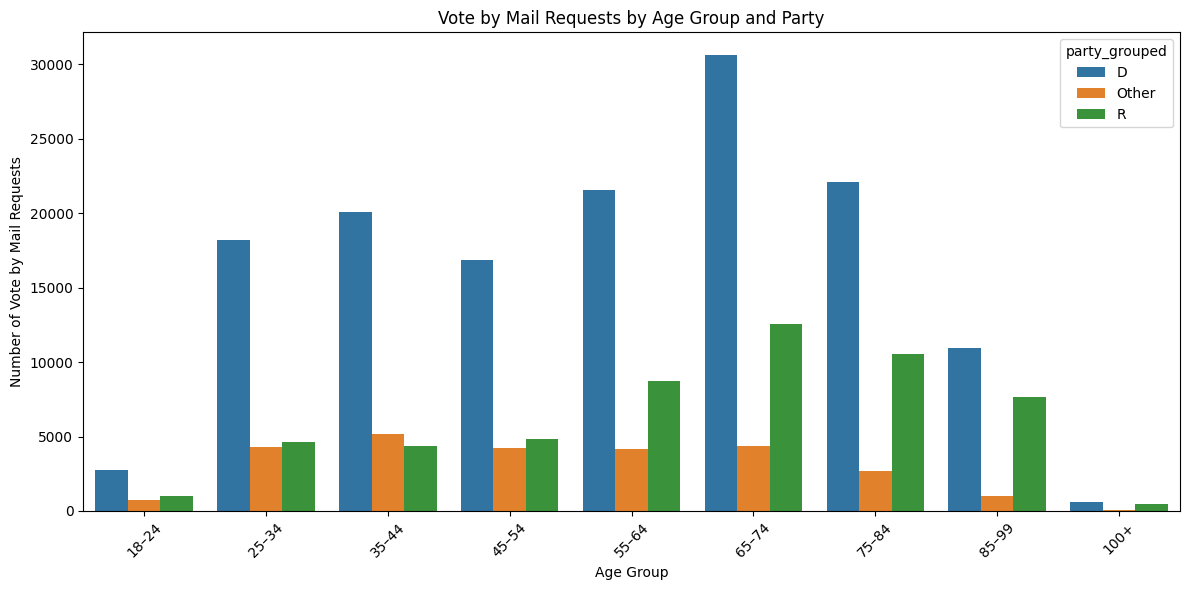

Relationship between Age, Party, and Vote by Mail Requests:
   party_grouped age_group  vote_by_mail_requests
0              D     18–24                   2775
1              D     25–34                  18220
2              D     35–44                  20060
3              D     45–54                  16884
4              D     55–64                  21543
5              D     65–74                  30629
6              D     75–84                  22086
7              D     85–99                  10968
8              D      100+                    586
9          Other     18–24                    717
10         Other     25–34                   4327
11         Other     35–44                   5167
12         Other     45–54                   4208
13         Other     55–64                   4182
14         Other     65–74                   4345
15         Other     75–84                   2653
16         Other     85–99                   1005
17         Other      100+              

In [45]:
# Plot using age buckets and party_grouped
plt.figure(figsize=(12, 6))
sns.barplot(x='age_group', y='vote_by_mail_requests', hue='party_grouped', data=application_in.groupby(['party_grouped', 'age_group']).size().reset_index(name='vote_by_mail_requests'))
plt.title('Vote by Mail Requests by Age Group and Party')
plt.xlabel('Age Group')
plt.ylabel('Number of Vote by Mail Requests')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Printout:
print("Relationship between Age, Party, and Vote by Mail Requests:")
print(application_in.groupby(['party_grouped', 'age_group']).size().reset_index(name='vote_by_mail_requests'))


What was the median latency from when each legislative district issued their application and when the ballot was returned?

In [46]:
# Convert to datetime, handling errors
application_in['appissuedate'] = pd.to_datetime(application_in['appissuedate'], errors='coerce')
application_in['ballotreturneddate'] = pd.to_datetime(application_in['ballotreturneddate'], errors='coerce')

# Calculate latency in days
application_in['latency_days'] = (application_in['ballotreturneddate'] - application_in['appissuedate']).dt.days

# Drop rows where latency is NaN (e.g., missing return dates)
latency_data = application_in.dropna(subset=['latency_days'])

# Group by legislative district and calculate median
median_latency = latency_data.groupby('legislative')['latency_days'].median().reset_index()

# Sort and view
median_latency = median_latency.sort_values(by='latency_days', ascending=False)
print(median_latency.head(20))

                    legislative  latency_days
21    11TH LEGISLATIVE DISTRICT         163.0
32    12TH LEGISLATIVE DISTRICT         160.0
30   128TH LEGISLATIVE DISTRICT          67.0
158    5TH LEGISLATIVE DISTRICT          67.0
82   175TH LEGISLATIVE DISTRICT          65.0
33   130TH LEGISLATIVE DISTRICT          64.0
90   182ND LEGISLATIVE DISTRICT          64.0
76    16TH LEGISLATIVE DISTRICT          63.0
28   126TH LEGISLATIVE DISTRICT          63.0
31   129TH LEGISLATIVE DISTRICT          63.0
111  200TH LEGISLATIVE DISTRICT          63.0
187   86TH LEGISLATIVE DISTRICT          62.0
124   29TH LEGISLATIVE DISTRICT          61.0
54    14TH LEGISLATIVE DISTRICT          61.0
173   73RD LEGISLATIVE DISTRICT          60.0
59   154TH LEGISLATIVE DISTRICT          60.0
186   85TH LEGISLATIVE DISTRICT          60.0
92   184TH LEGISLATIVE DISTRICT          59.0
176   76TH LEGISLATIVE DISTRICT          58.5
185   84TH LEGISLATIVE DISTRICT          58.5


What is the congressional district that has the highest frequency of ballot requests?

In [47]:
# count the ballot requests
top_congressional = application_in['congressional'].value_counts().idxmax()
top_count = application_in['congressional'].value_counts().max()

print(f"The congressional district with the highest number of ballot requests is {top_congressional} with {top_count} requests.")


The congressional district with the highest number of ballot requests is 4TH CONGRESSIONAL DISTRICT with 21752 requests.


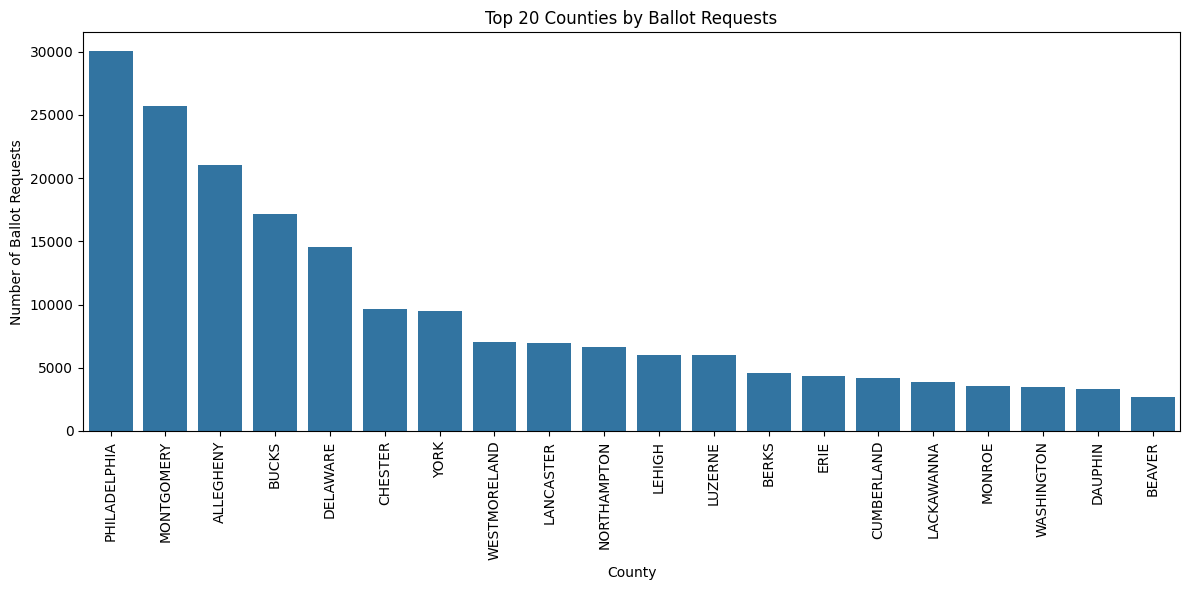

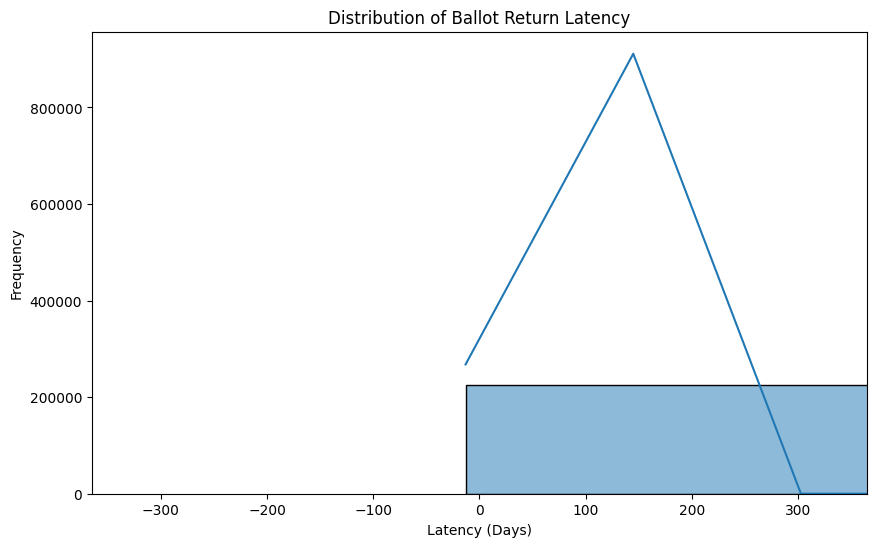

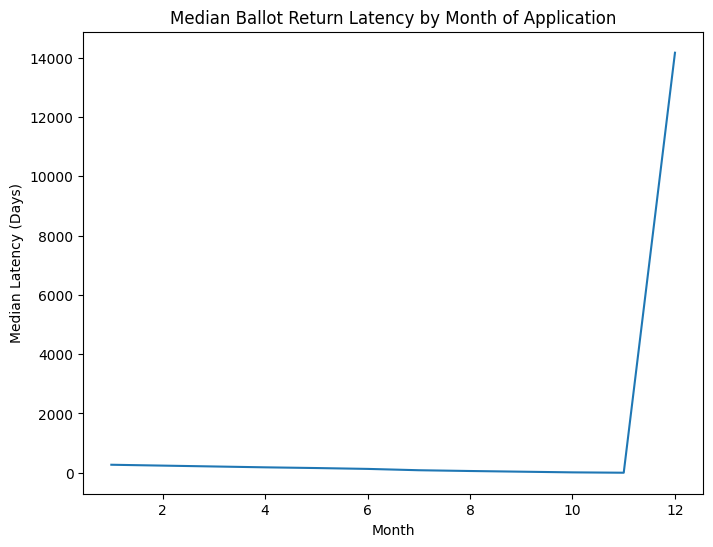

In [48]:
# Further Exploratory Data Analysis

# 1. Geographic Distribution: Explore ballot requests by county
county_counts = application_in['countyname'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=county_counts.index[:20], y=county_counts.values[:20]) # Top 20 counties
plt.xticks(rotation=90)
plt.title('Top 20 Counties by Ballot Requests')
plt.xlabel('County')
plt.ylabel('Number of Ballot Requests')
plt.tight_layout()
plt.show()

# 2.  Ballot Return Latency Analysis (detailed):
plt.figure(figsize=(10, 6))
sns.histplot(application_in['latency_days'], kde=True, bins=30)
plt.title('Distribution of Ballot Return Latency')
plt.xlabel('Latency (Days)')
plt.ylabel('Frequency')
plt.xlim(-365, 365)
plt.show()

# 3.  Relationship between Application Issue Date and Latency:
application_in['appissuedate'] = pd.to_datetime(application_in['appissuedate'])
application_in['month_issued'] = application_in['appissuedate'].dt.month
monthly_latency = application_in.groupby('month_issued')['latency_days'].median()
plt.figure(figsize=(8, 6))
sns.lineplot(x=monthly_latency.index, y=monthly_latency.values)
plt.title('Median Ballot Return Latency by Month of Application')
plt.xlabel('Month')
plt.ylabel('Median Latency (Days)')
plt.show()





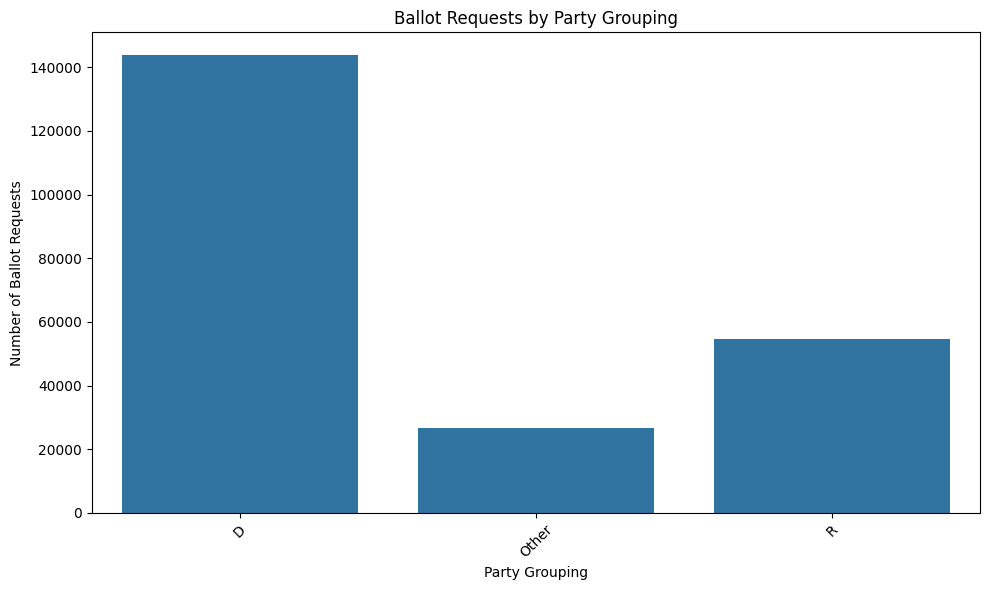

In [49]:
# calculate requests by party
party_requests = application_in.groupby('party_grouped').size().reset_index(name='ballot_requests')

# plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.barplot(x='party_grouped', y='ballot_requests', data=party_requests)
plt.title('Ballot Requests by Party Grouping')
plt.xlabel('Party Grouping')
plt.ylabel('Number of Ballot Requests')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

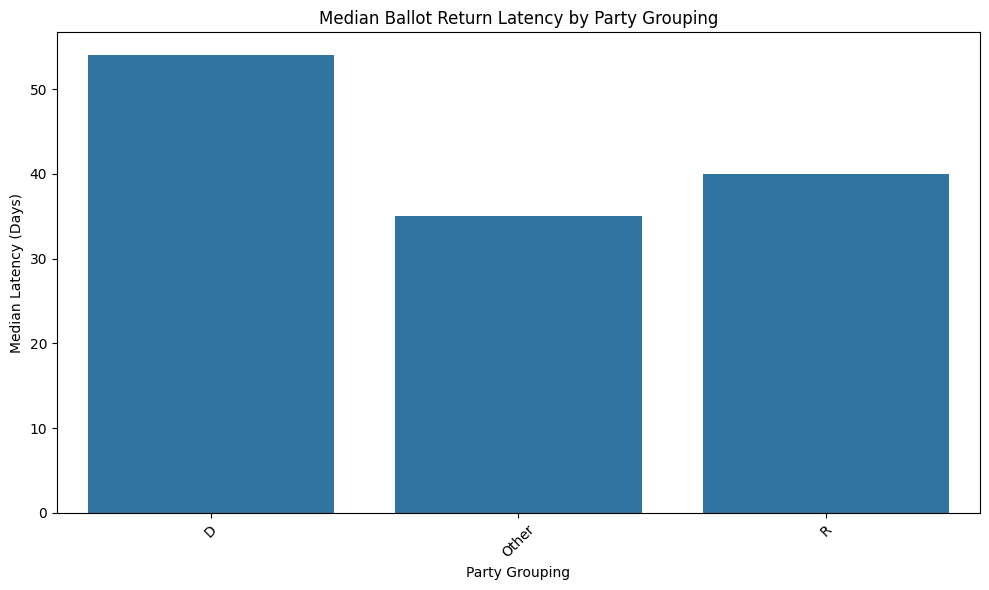

In [50]:
latency_by_party = application_in.groupby('party_grouped')['latency_days'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='party_grouped', y='latency_days', data=latency_by_party)
plt.title('Median Ballot Return Latency by Party Grouping')
plt.xlabel('Party Grouping')
plt.ylabel('Median Latency (Days)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation Analysis:
age and latency_days: To check if there's a relationship between voter age and ballot return time.

month_issued and latency_days: To see if the month of application issuance is related to return time.

In [51]:
correlations = application_in[['age', 'month_issued', 'latency_days']].corr()
print(correlations)

                   age  month_issued  latency_days
age           1.000000     -0.180520      0.095013
month_issued -0.180520      1.000000     -0.548824
latency_days  0.095013     -0.548824      1.000000


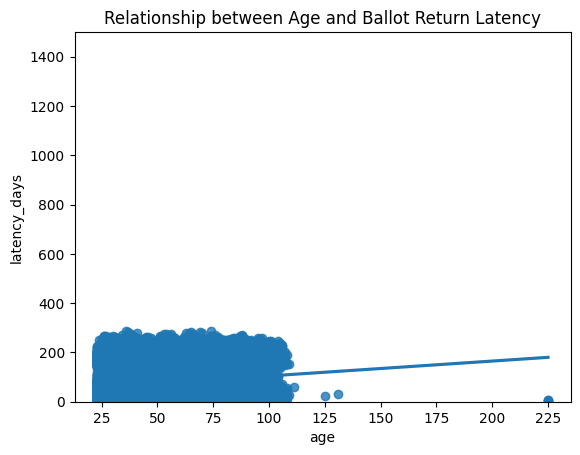

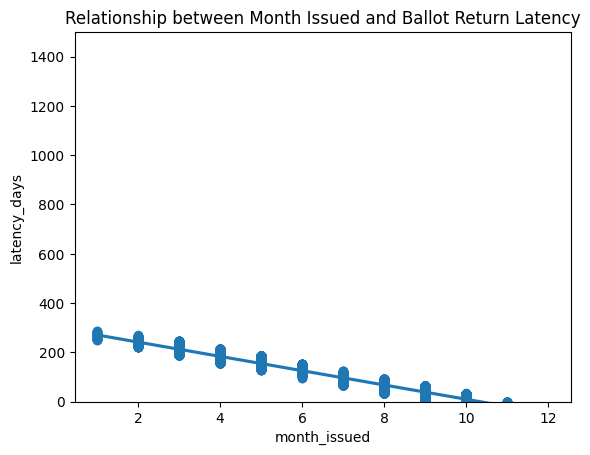

In [53]:
# plot further relationships with regression line
sns.regplot(x='age', y='latency_days', data=application_in)
plt.title('Relationship between Age and Ballot Return Latency')
plt.ylim(0, 1500)  # Set y-axis limits
plt.show()

sns.regplot(x='month_issued', y='latency_days', data=application_in)
plt.title('Relationship between Month Issued and Ballot Return Latency')
plt.ylim(0, 1500)  # Set y-axis limits
plt.show()

# Summary of Key Findings

## Overall:
 The dataset reveals trends in mail-in ballot requests in Pennsylvania.  Analysis focuses on applicant demographics, geographic distribution, party affiliation and ballot return times.

# Key Findings:
 1. Geographic Distribution:  Ballot request frequency varies significantly across counties, with some counties showing considerably higher request numbers than others.  
 2. Age/ latency and Party Affiliation
 3. Ballot Return Latency...return times vary across legislative districts.  Additionally, the overall distribution of latency, along with trends in latency over time reveal patterns worth further investigation.
 4. Significant outliers exist, particularly in latency

# Further Research:
 1. Investigate the reasons for the variation in ballot request counts across counties.
 3. Analyze the invalid data dataset for any patterns in the missingness